# Meal Allowance Draft

In [24]:
# Load Libraries
library(ggplot2)
library(dplyr)
library(lubridate) 
library(RColorBrewer)
library(viridis)
library(scales)
library(tidyr)  
library(cluster)
library(httr)
library(jsonlite)
library(dotenv)

In [25]:
dotenv::load_dot_env(".env")
username <- Sys.getenv("GEONAMES_USERNAME")
options(repr.plot.width = 14, repr.plot.height = 11)

### Data Loading and Inspection

In [47]:
# Load CSV
food_prices <- read.csv("food_prices_ph_cleaned.csv", stringsAsFactors = TRUE)
employees <- read.csv("employees_details_cleaned.csv", stringsAsFactors = TRUE)

# Convert Date to date format
food_prices$Date <- as.Date(food_prices$Date)

# Ensure that numeric columns are properly formatted
food_prices$Price <- as.numeric(food_prices$Price)

# Extract year
food_prices$Year <- year(food_prices$Date)


# Filter for dates from 2019 onwards and exclude Unit entries
food_prices <- food_prices %>%
  filter(year(Date) >= 2019, Unit != "Unit")


# Exclude Unit entries
food_prices <- food_prices %>%
  filter(Unit != "Unit")


In [48]:
# Check Data Types
str(food_prices)

# Check Data Types
str(employees)

'data.frame':	66171 obs. of  13 variables:
 $ X         : int  30711 30712 30713 30715 30716 30717 30718 30719 30720 30721 ...
 $ Date      : Date, format: "2019-01-15" "2019-01-15" ...
 $ Region    : Factor w/ 17 levels "Autonomous region in Muslim Mindanao",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Location  : Factor w/ 79 levels "Abra","Agusan del Norte",..: 43 43 43 43 43 43 43 43 43 43 ...
 $ Market    : Factor w/ 108 levels "Abra","Agusan del Norte",..: 89 89 89 89 89 89 89 89 89 89 ...
 $ Category  : Factor w/ 6 levels "cereals and tubers",..: 1 1 1 2 2 2 2 5 6 6 ...
 $ Commodity : Factor w/ 73 levels "Anchovies","Bananas (lakatan)",..: 55 59 70 21 44 45 46 6 10 10 ...
 $ Unit      : Factor w/ 3 levels "750 ML","KG",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Price.Flag: Factor w/ 2 levels "actual","aggregate": 1 1 1 1 1 1 1 1 1 1 ...
 $ Price.Type: Factor w/ 3 levels "Farm Gate","Retail",..: 2 2 2 2 2 2 2 2 2 3 ...
 $ Currency  : Factor w/ 1 level "PHP": 1 1 1 1 1 1 1 1 1 1 ...
 $ Price     : num  65.

In [49]:
# columns
colnames(food_prices)

colnames(employees)

[1] "X"          "Date"       "Region"     "Location"   "Market"    
 [6] "Category"   "Commodity"  "Unit"       "Price.Flag" "Price.Type"
[11] "Currency"   "Price"      "Year"

[1] "X"                       "Employee.."             
 [3] "Last.Name"               "First.Name"             
 [5] "Birthday"                "Address"                
 [7] "Phone.Number"            "SSS.."                  
 [9] "Philhealth.."            "TIN.."                  
[11] "Pag.ibig.."              "Status"                 
[13] "Position"                "Immediate.Supervisor"   
[15] "Basic.Salary"            "Rice.Subsidy"           
[17] "Phone.Allowance"         "Clothing.Allowance"     
[19] "Gross.Semi.monthly.Rate" "Hourly.Rate"

In [50]:
# Check for missing values
sum(is.na(food_prices))
sum(is.na(employees))

[1] 0

[1] 0

### OPTION 1: Base Meal Price Model

In [51]:
# Ingredient categories
ingredient_categories <- list(
  protein = c("Meat (pork)", "Meat (beef, chops with bones)", "Meat (chicken, whole)", "Fish (fresh)", "Fish (frigate tuna)", "Fish (mackerel, fresh)", "Fish (tilapia)", "Fish (roundscad)", "Fish (slipmouth)", "Fish (threadfin bream)", "Beans (mung)", "Groundnuts (unshelled)", "Groundnuts (shelled)", "Eggs", "Eggs (duck)", "Meat (pork, with bones)", "Meat (beef)", "Meat (pork, hock)", "Meat (pork, with fat)", "Shrimp (endeavor)", "Shrimp (tiger)", "Crab", "Fish (redbelly yellowtail fusilier)", "Fish (milkfish)"),
  carbohydrate = c("Rice (milled, superior)", "Rice (regular, milled)", "Rice (premium)", "Rice (special)", "Rice (well milled)", "Maize flour (yellow)", "Maize flour (white)", "Maize (yellow)", "Maize (white)", "Potatoes (Irish)", "Sweet potatoes", "Semolina (white)", "Semolina (yellow)", "Taro"),
  vegetables = c("Cabbage", "Cabbage (chinese)", "Carrots", "Garlic", "Onions (red)", "Onions (white)", "Tomatoes", "Eggplants", "Bitter melon", "Bottle gourd", "Choko", "Water spinach", "Sweet Potato leaves", "Choko", "Water spinach"),
  fruits = c("Bananas (latundan)", "Bananas (saba)", "Bananas (lakatan)", "Mangoes (carabao)", "Mangoes (piko)", "Pineapples", "Coconut"),
  oils_and_condiments = c("Oil (cooking)", "Sugar (brown)", "Sugar (white)", "Garlic (large)", "Garlic (small)", "Ginger", "Calamansi", "Anchovies")
)

# Category assignment
food_prices$Category <- sapply(food_prices$Commodity, function(x) {
  if (x %in% ingredient_categories$protein) return("Protein")
  if (x %in% ingredient_categories$carbohydrate) return("Carbohydrate")
  if (x %in% ingredient_categories$vegetables) return("Vegetable")
  if (x %in% ingredient_categories$fruits) return("Fruit")
  if (x %in% ingredient_categories$oils_and_condiments) return("Oils and Condiments")
  return("Other")
})

# Unit price calculation (per kg)
food_prices <- food_prices %>%
  mutate(UnitPrice_kg = ifelse(Unit == "750 ML" & Commodity == "Oil (cooking)", Price / (0.75 * 0.92),
                               ifelse(Unit == "KG", Price, NA))) %>%
  filter(!is.na(UnitPrice_kg)) # Remove rows where UnitPrice_kg is NA

In [53]:
# Average price per category per year
yearly_avg_prices <- food_prices %>%
  group_by(Year, Category) %>%
  summarize(Avg_Price = mean(UnitPrice_kg, na.rm = TRUE), .groups="keep") %>%
  pivot_wider(names_from = Category, values_from = Avg_Price)

# Imputation (fill NA with previous year's value, if available, otherwise 0)
yearly_avg_prices <- yearly_avg_prices %>%
  arrange(Year) %>%
  mutate(
    Protein = ifelse(is.na(Protein), lag(Protein, default = 0), Protein),
    Carbohydrate = ifelse(is.na(Carbohydrate), lag(Carbohydrate, default = 0), Carbohydrate),
    Vegetable = ifelse(is.na(Vegetable), lag(Vegetable, default = 0), Vegetable),
    Fruit = ifelse(is.na(Fruit), lag(Fruit, default = 0), Fruit),
    `Oils and Condiments` = ifelse(is.na(`Oils and Condiments`), lag(`Oils and Condiments`, default = 0), `Oils and Condiments`),
    Other = ifelse(is.na(Other), lag(Other, default = 0), Other)
  )

# Replace the first NA values in each column with 0.
yearly_avg_prices <- yearly_avg_prices %>%
  mutate(
    Protein = ifelse(is.na(Protein), 0, Protein),
    Carbohydrate = ifelse(is.na(Carbohydrate), 0, Carbohydrate),
    Vegetable = ifelse(is.na(Vegetable), 0, Vegetable),
    Fruit = ifelse(is.na(Fruit), 0, Fruit),
    `Oils and Condiments` = ifelse(is.na(`Oils and Condiments`), 0, `Oils and Condiments`),
    Other = ifelse(is.na(Other), 0, Other)
  )

In [54]:
# Meal composition in grams
protein_weight <- 175 # grams
carb_weight <- 250 # grams
veg_weight <- 100 # grams
fruit_weight <- 150 # grams
oils_and_condiments_weight <- 10 # grams

# Calculate base meal price per year
yearly_avg_prices$Base_Meal_Price <-
  (protein_weight * yearly_avg_prices$Protein / 1000) +
  (carb_weight * yearly_avg_prices$Carbohydrate / 1000) +
  (veg_weight * yearly_avg_prices$Vegetable / 1000) +
  (fruit_weight * yearly_avg_prices$Fruit / 1000) +
  (oils_and_condiments_weight * yearly_avg_prices$`Oils and Condiments` / 1000)

print(yearly_avg_prices)

# A tibble: 4 × 8
# Groups:   Year [4]
   Year Carbohydrate Protein Vegetable Fruit `Oils and Condiments` Other
  <dbl>        <dbl>   <dbl>     <dbl> <dbl>                 <dbl> <dbl>
1  2019         40.4    170.      60.4   0                      0    0  
2  2020         47.8    177.      69.3  60.5                  104.  56.8
3  2021         43.0    187.      81.3  63.7                  112.  58.7
4  2022         53.1    193.      90.3  63.1                  117.  66.4
# ℹ 1 more variable: Base_Meal_Price <dbl>


In [55]:
# Find the latest year
latest_year <- max(yearly_avg_prices$Year)

# Extract the Base_Meal_Price for the latest year
latest_base_price <- yearly_avg_prices %>%
  filter(Year == latest_year) %>%
  pull(Base_Meal_Price)

# Print the recommended base price
print(paste("Recommended Base Meal Price:", latest_base_price, "PHP"))

[1] "Recommended Base Meal Price: 66.711943077597 PHP"


In [56]:
# Assuming latest_base_price is 78 PHP
latest_base_price <- latest_base_price

# Example scaling factor (adjust as needed)
scaling_factor <- 3.8

# Calculate the scaled base price
scaled_base_price <- latest_base_price * scaling_factor

# Print the scaled base price
print(paste("Scaled Base Meal Price:", scaled_base_price, "PHP"))

# Calculate the daily allowance for two meals.
daily_allowance <- scaled_base_price * 1 # adjust here if needed more than one meal a day
daily_allowance <- round(daily_allowance/10)*10

print(paste("Recommended Daily Meal Allowance:", daily_allowance, "PHP"))

[1] "Scaled Base Meal Price: 253.505383694869 PHP"
[1] "Recommended Daily Meal Allowance: 250 PHP"


#### OPTION 1 Visualization

**Trend in Food Prices Over Time**

To understand how food prices have changed over recent years, we can plot the average unit price of different food categories over time. This helps in identifying trends that might impact meal allowance calculations.

Explanation: This line graph shows how the average prices of different food categories have changed from 2019 onwards. It helps identify which categories have seen significant price increases, which can inform decisions on meal allowances.

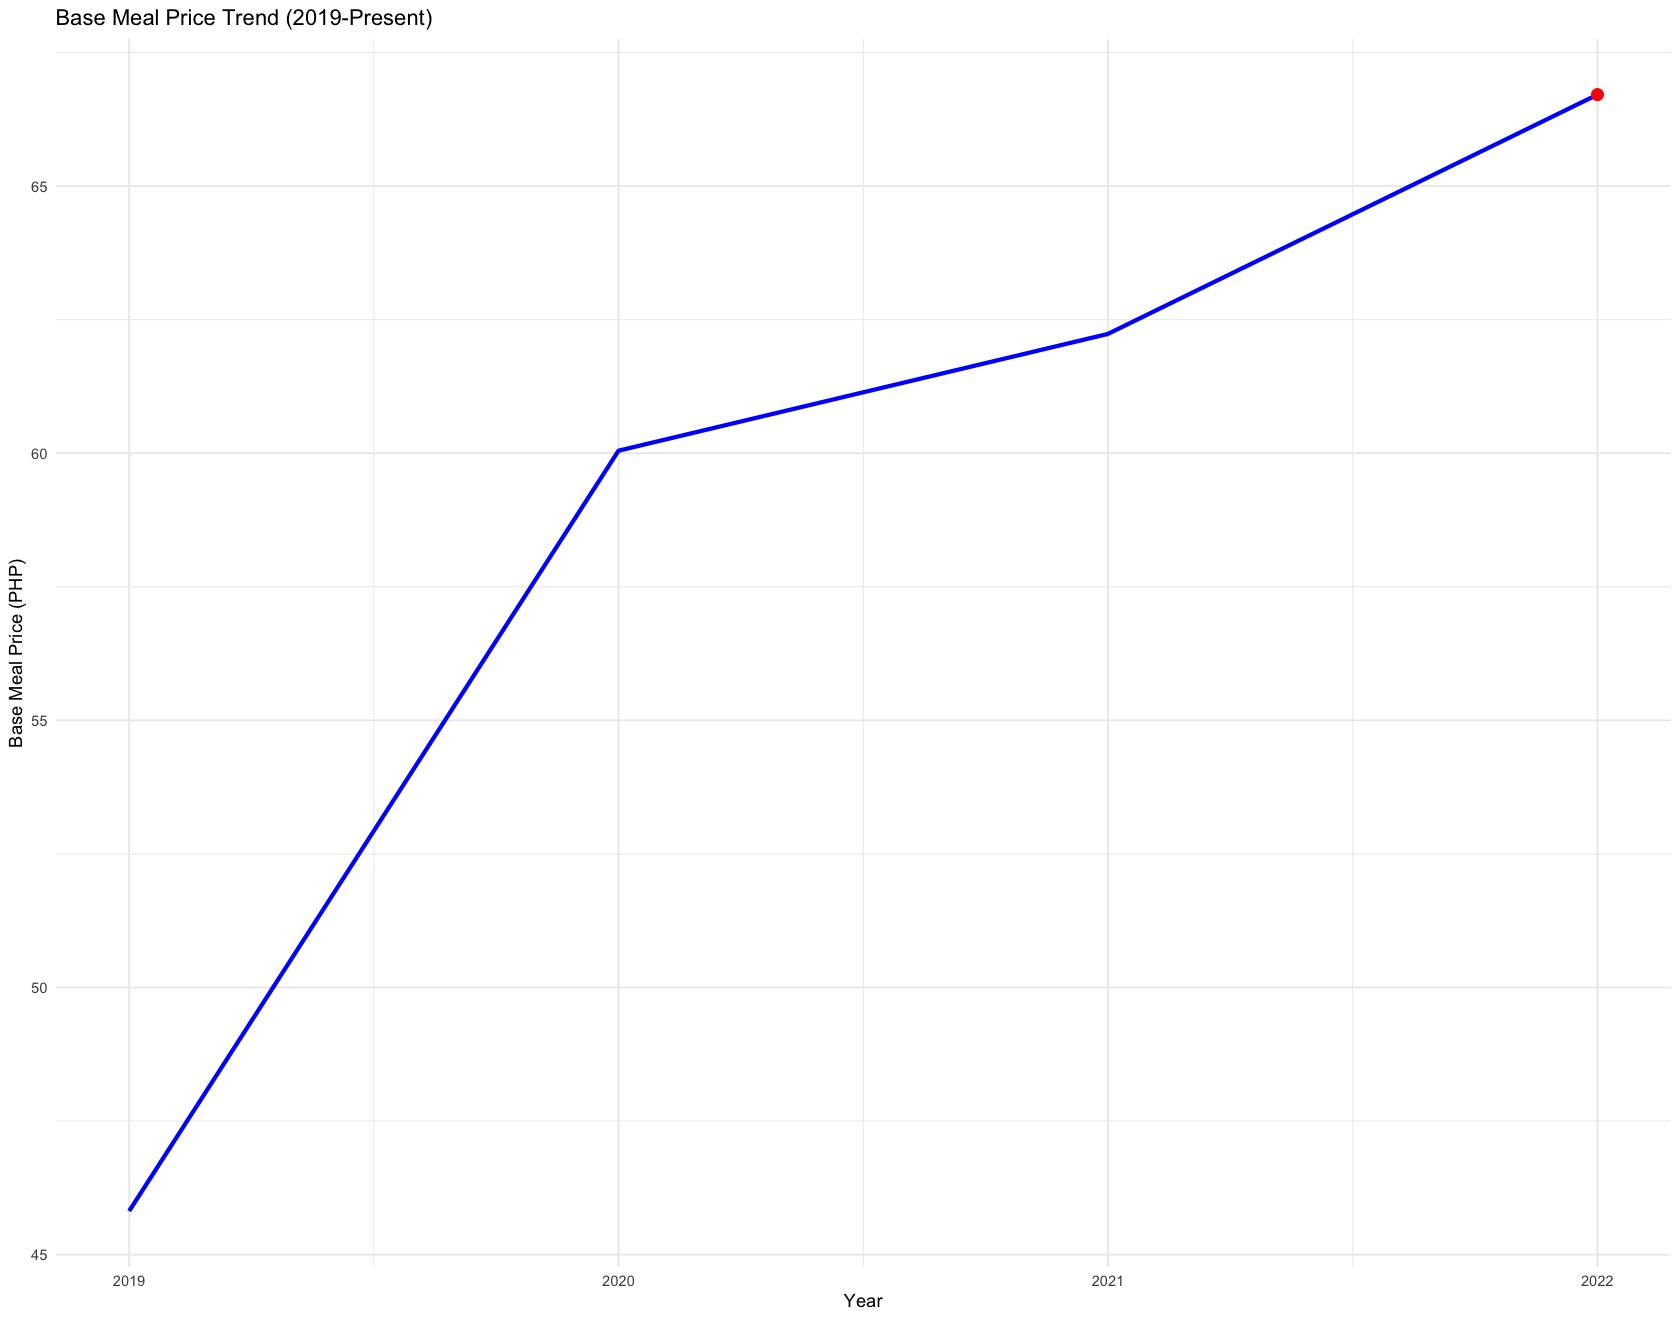

In [57]:
ggplot(yearly_avg_prices, aes(x = Year, y = Base_Meal_Price)) +
  geom_line(color = "blue", linewidth = 1.2) +
  geom_point(data = yearly_avg_prices[yearly_avg_prices$Year == max(yearly_avg_prices$Year), ], color = "red", size = 3) +
  labs(title = "Base Meal Price Trend (2019-Present)", x = "Year", y = "Base Meal Price (PHP)") +
  theme_minimal()

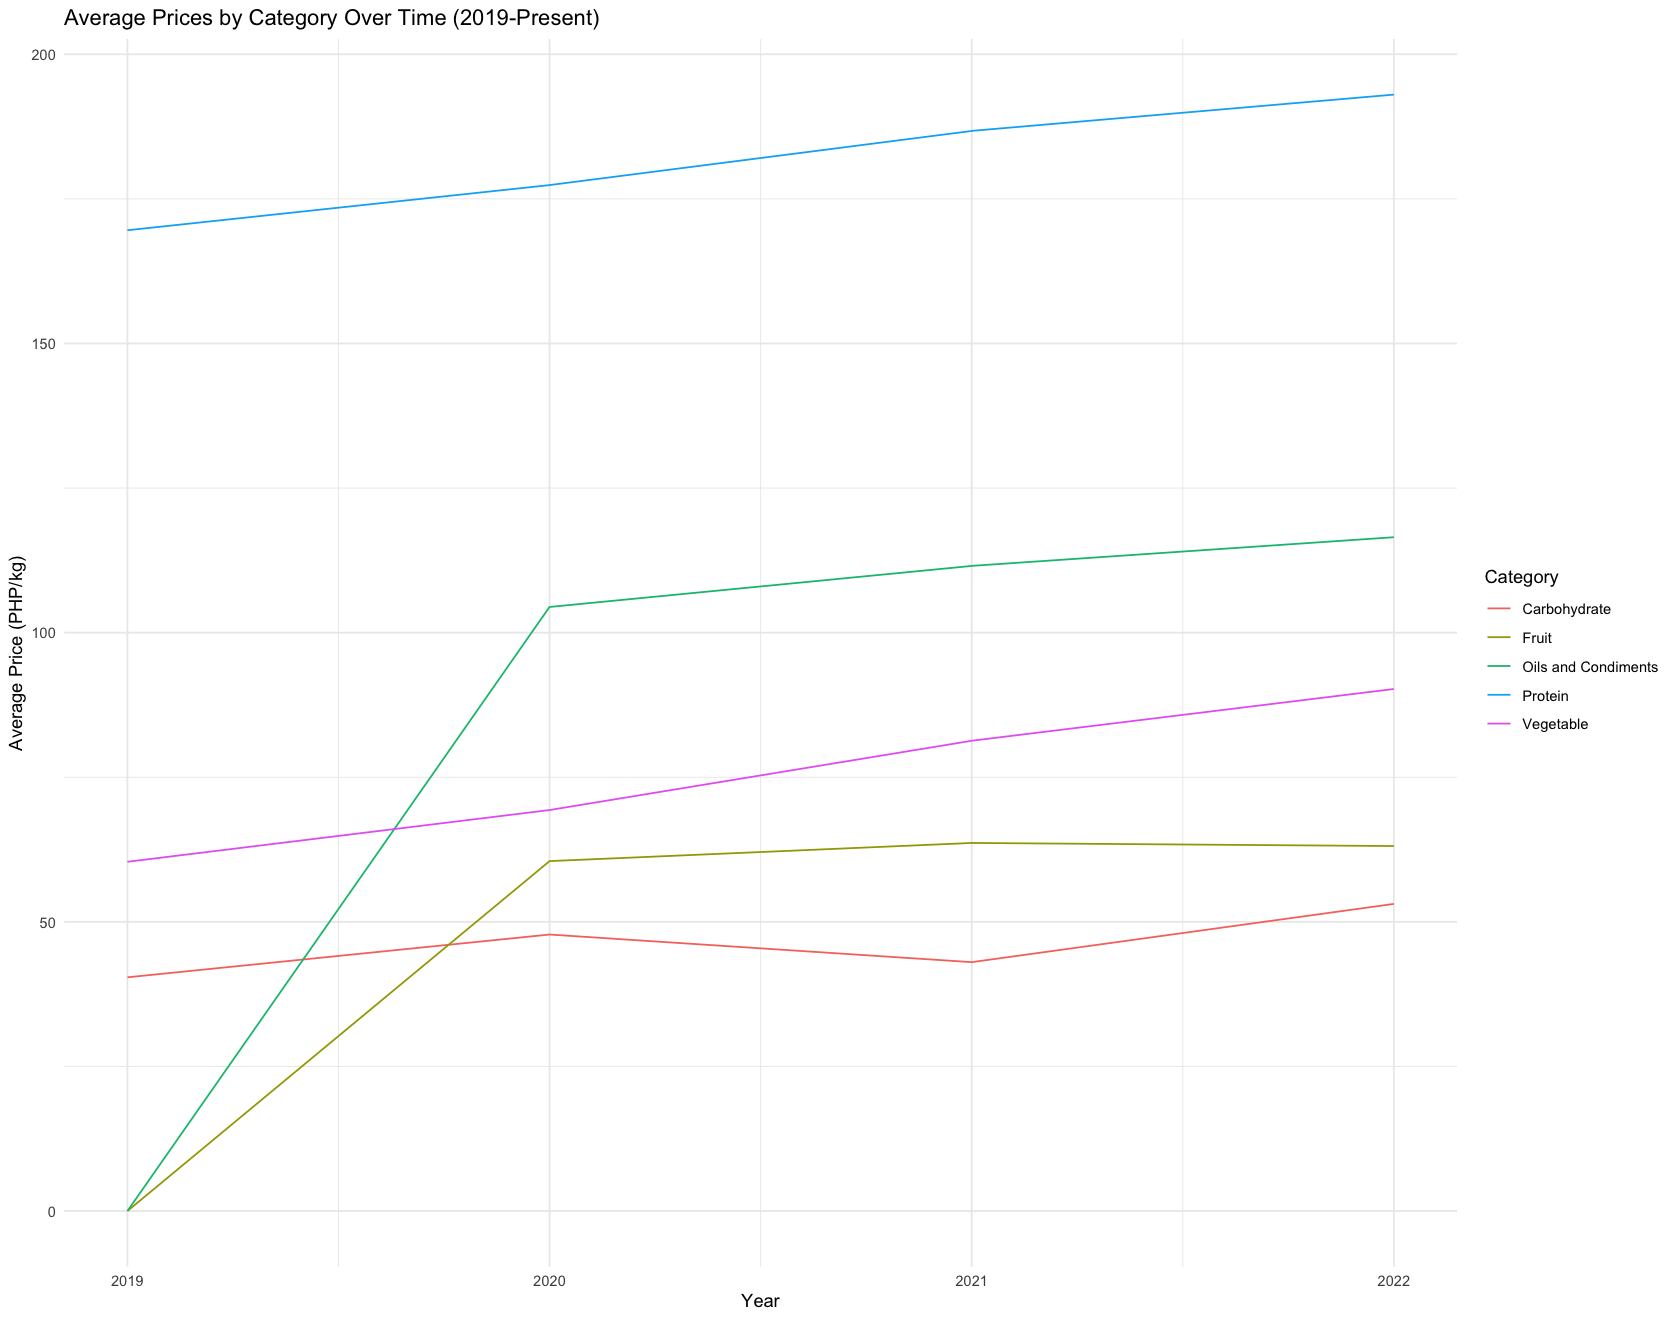

In [58]:
# Line Chart Example
yearly_avg_prices_long <- yearly_avg_prices %>%
  tidyr::pivot_longer(cols = c("Protein", "Carbohydrate", "Vegetable", "Fruit", "Oils and Condiments"),
               names_to = "Category", values_to = "Avg_Price")

ggplot(yearly_avg_prices_long, aes(x = Year, y = Avg_Price, color = Category)) +
  geom_line() +
  labs(title = "Average Prices by Category Over Time (2019-Present)", x = "Year", y = "Average Price (PHP/kg)") +
  theme_minimal()

**Distribution of Food Prices by Category**

Understanding the distribution of prices within each category can help in setting realistic meal allowances. A box plot can effectively visualize this distribution.

Explanation: This box plot illustrates the range and variability of prices within each food category. It's useful for identifying categories with high price variability, which might require more flexible meal allowances.

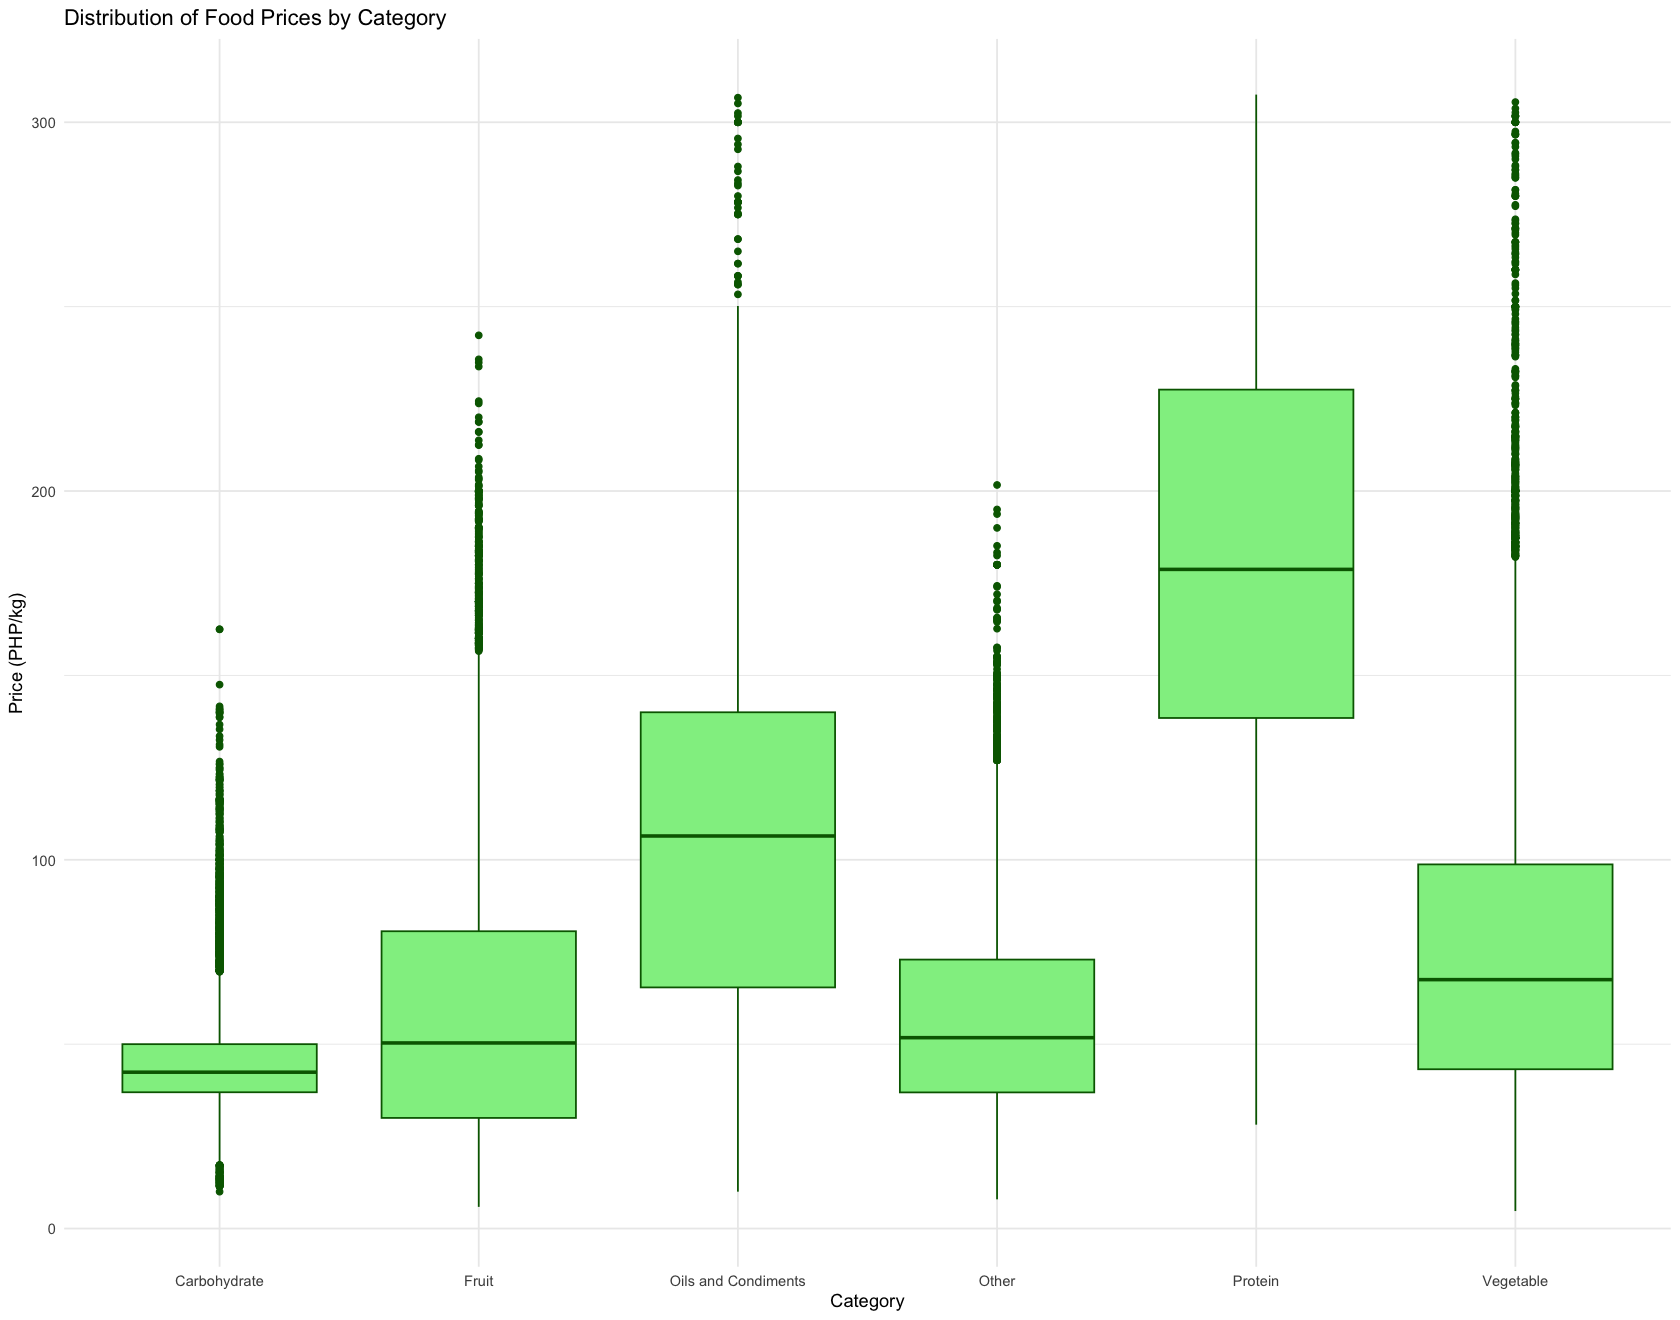

In [82]:
# Plot distribution of unit prices by category
# Boxplot example for all categories
ggplot(food_prices, aes(x = Category, y = UnitPrice_kg)) +
  geom_boxplot(fill = "lightgreen", color = "darkgreen") +
  labs(title = "Distribution of Food Prices by Category", x = "Category", y = "Price (PHP/kg)") +
  theme_minimal()

In [59]:
key_data <- data.frame(
  Metric = c("Latest Year", "Base Meal Price (PHP)", "Scaling Factor", "Recommended Daily Allowance (PHP)"),
  Value = c(latest_year, latest_base_price, scaling_factor, daily_allowance)
)

print(key_data)

                             Metric      Value
1                       Latest Year 2022.00000
2             Base Meal Price (PHP)   66.71194
3                    Scaling Factor    3.80000
4 Recommended Daily Allowance (PHP)  250.00000


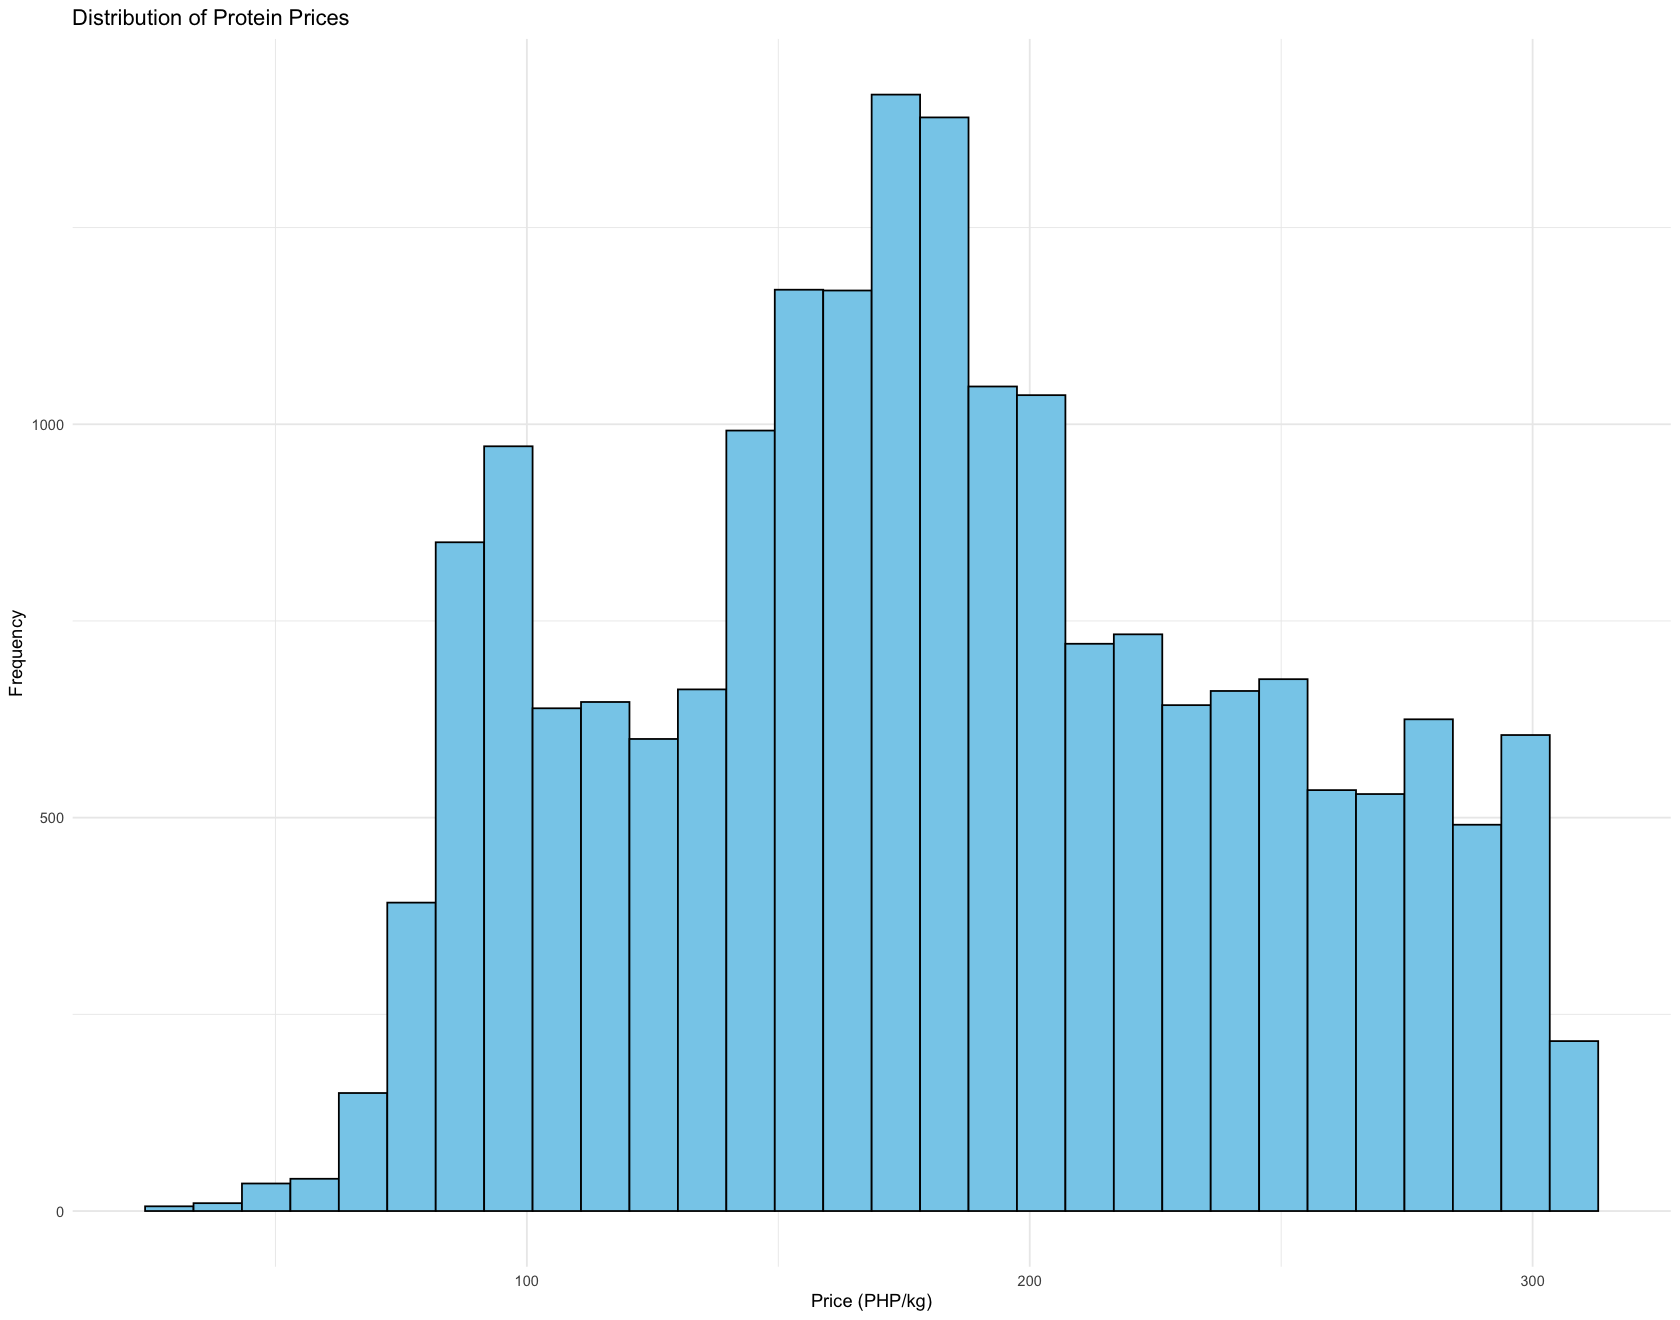

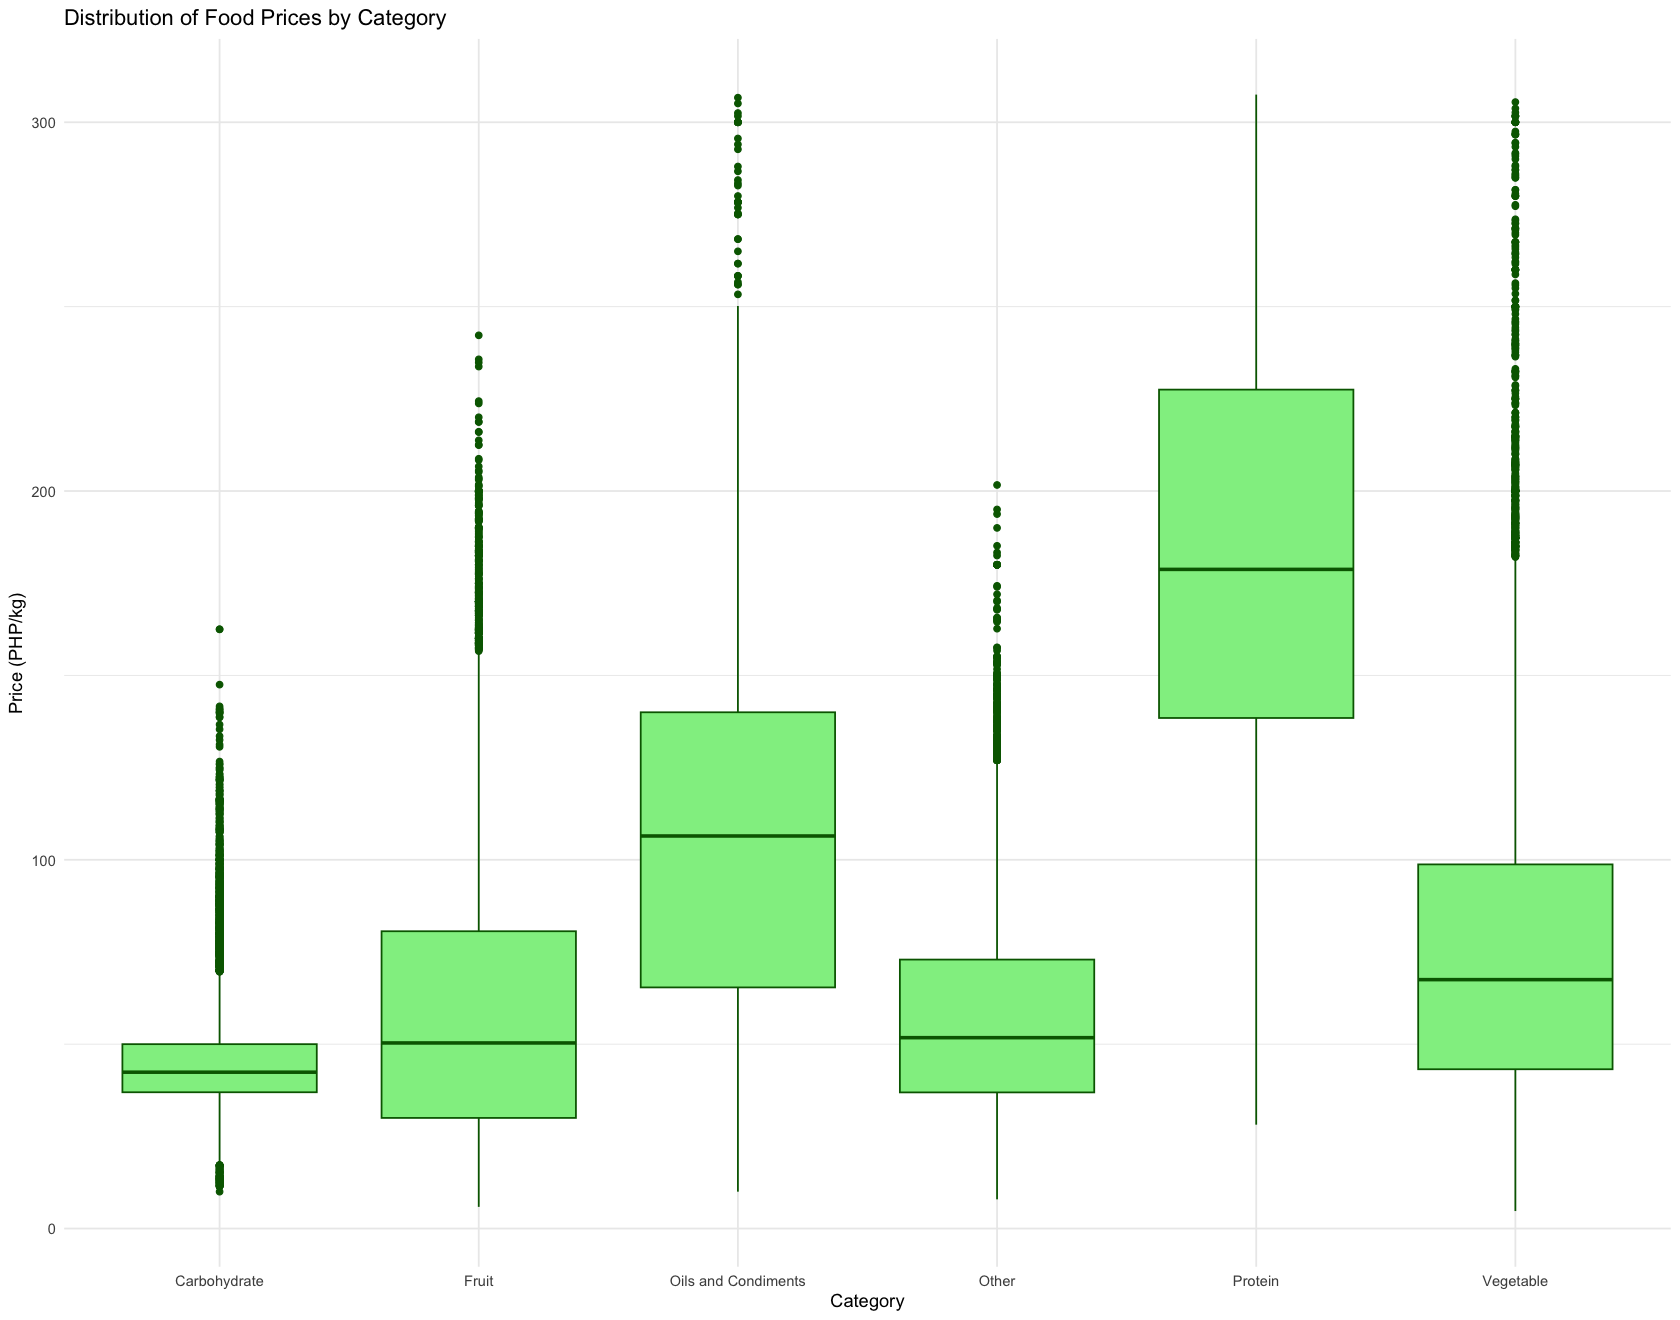

In [81]:
# Histogram Example for Protein
ggplot(food_prices %>% filter(Category == "Protein"), aes(x = UnitPrice_kg)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "black") +
  labs(title = "Distribution of Protein Prices", x = "Price (PHP/kg)", y = "Frequency") +
  theme_minimal()

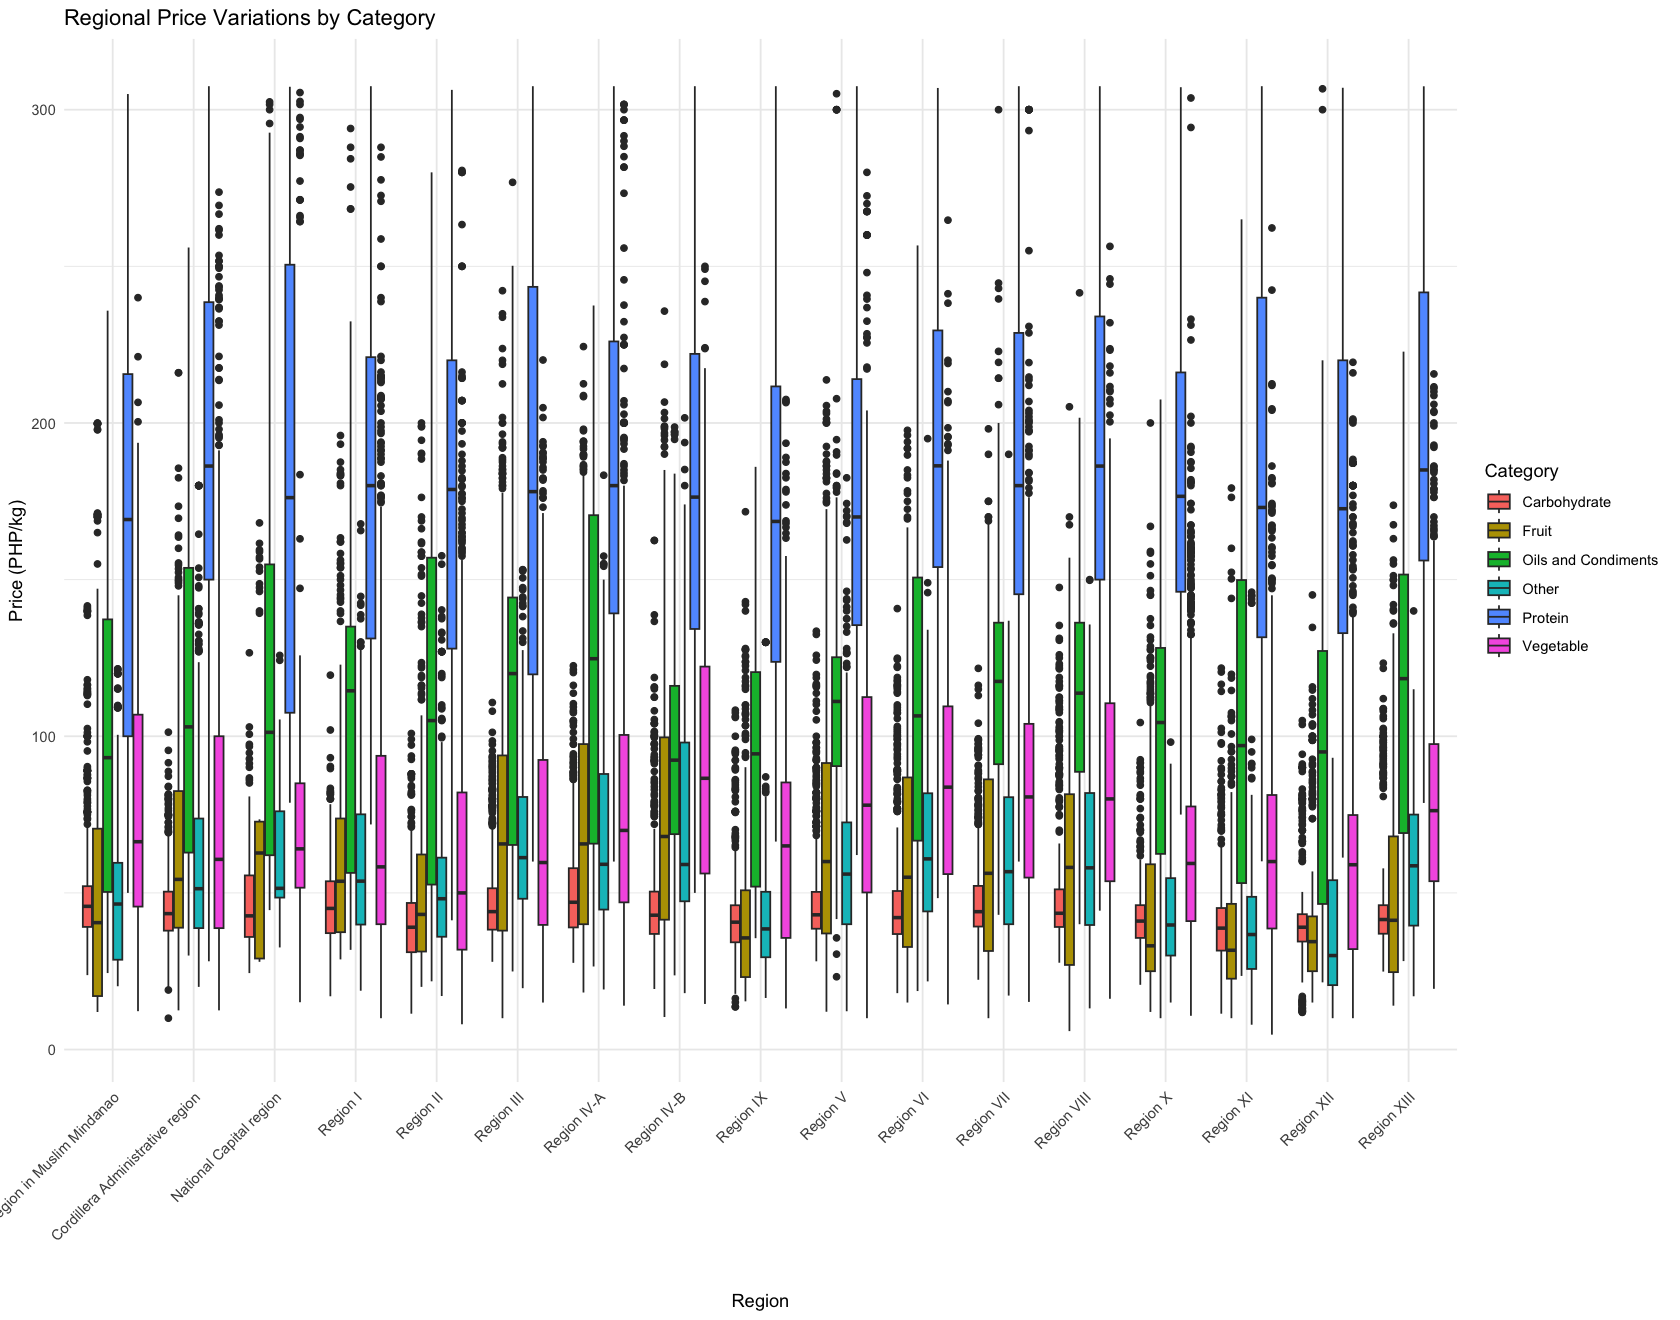

In [61]:
#Example of a boxplot by region and category.
ggplot(food_prices, aes(x = Region, y = UnitPrice_kg, fill = Category)) +
  geom_boxplot() +
  labs(title = "Regional Price Variations by Category", x = "Region", y = "Price (PHP/kg)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis labels

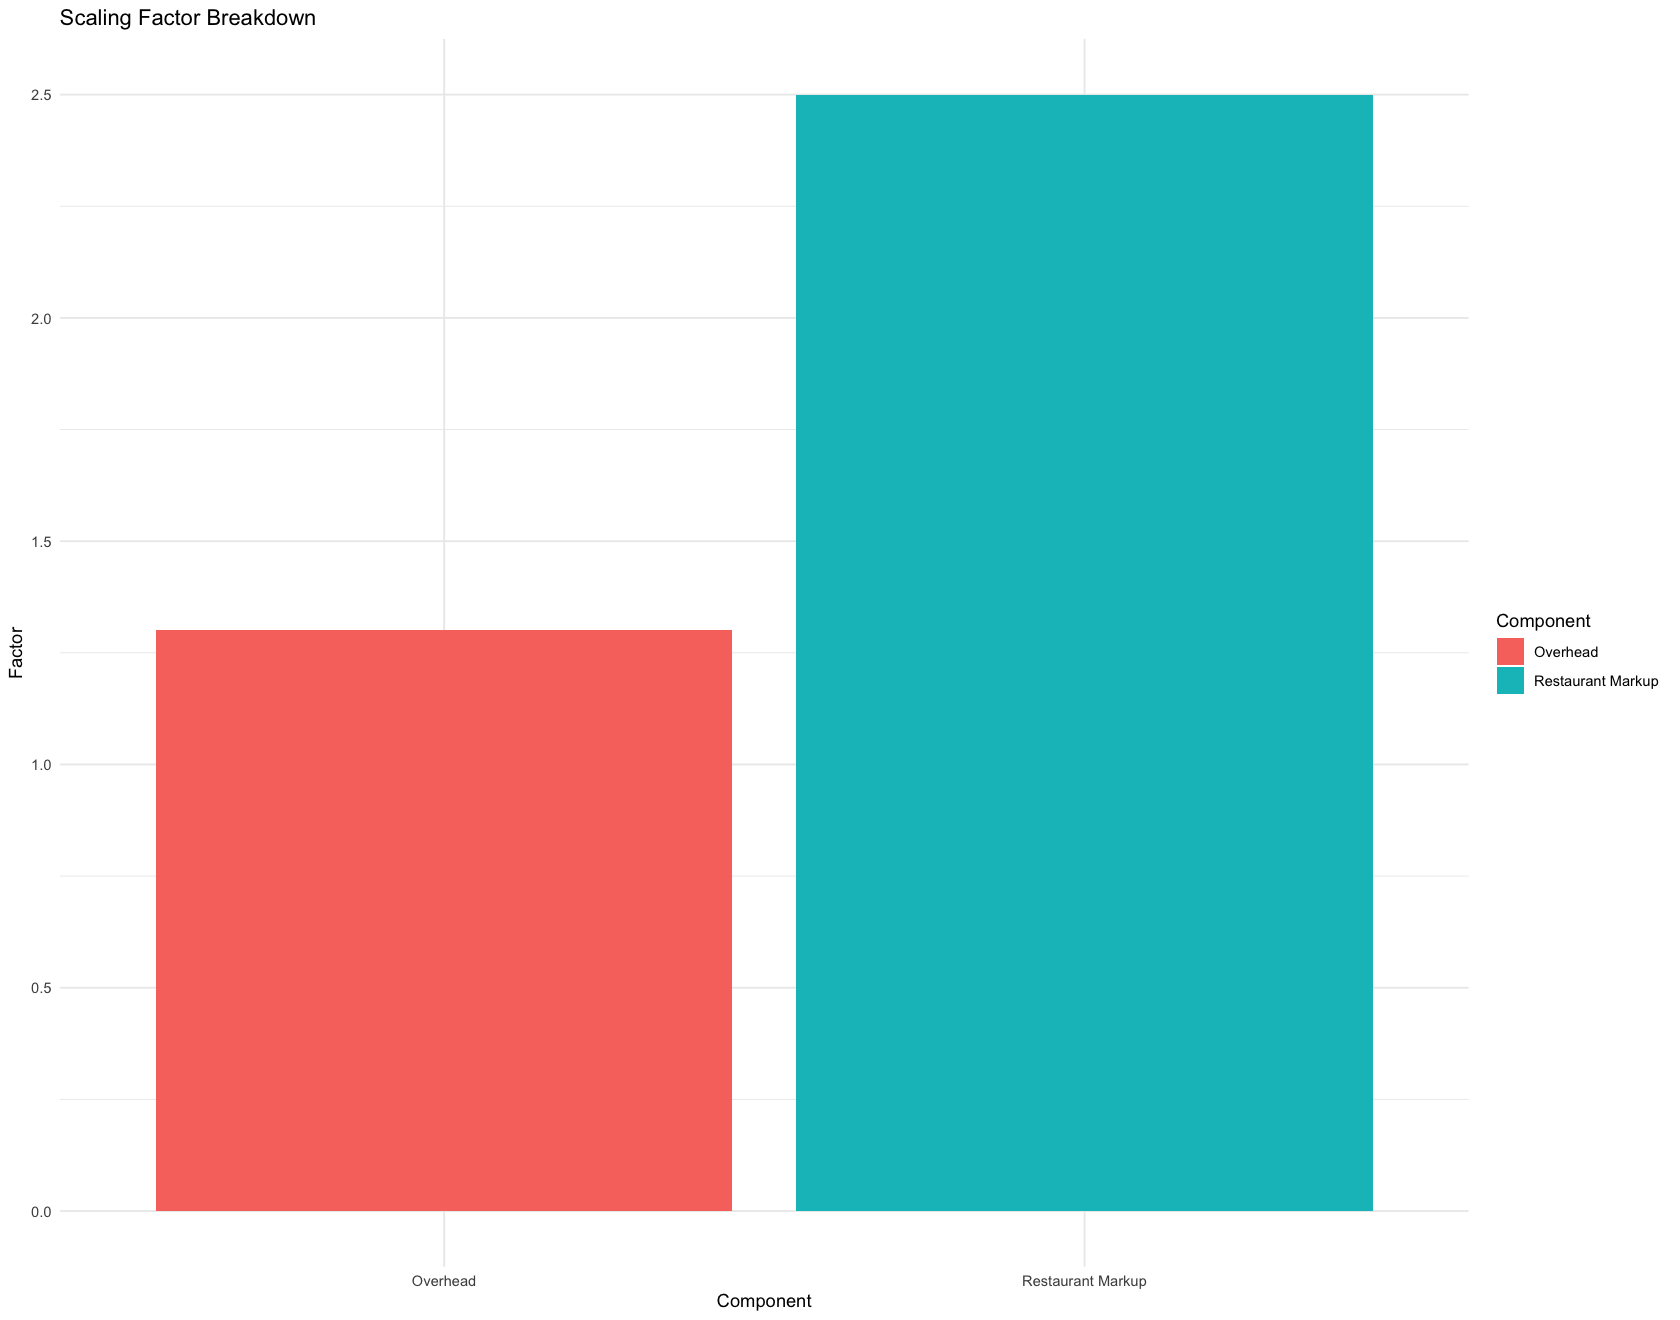

In [62]:
#Example of a bar chart.
scaling_data <- data.frame(
  Component = c("Restaurant Markup", "Overhead"),
  Factor = c(2.5, 1.3) #Example values.
)

ggplot(scaling_data, aes(x = Component, y = Factor, fill = Component)) +
  geom_bar(stat = "identity") +
  labs(title = "Scaling Factor Breakdown", x = "Component", y = "Factor") +
  theme_minimal()

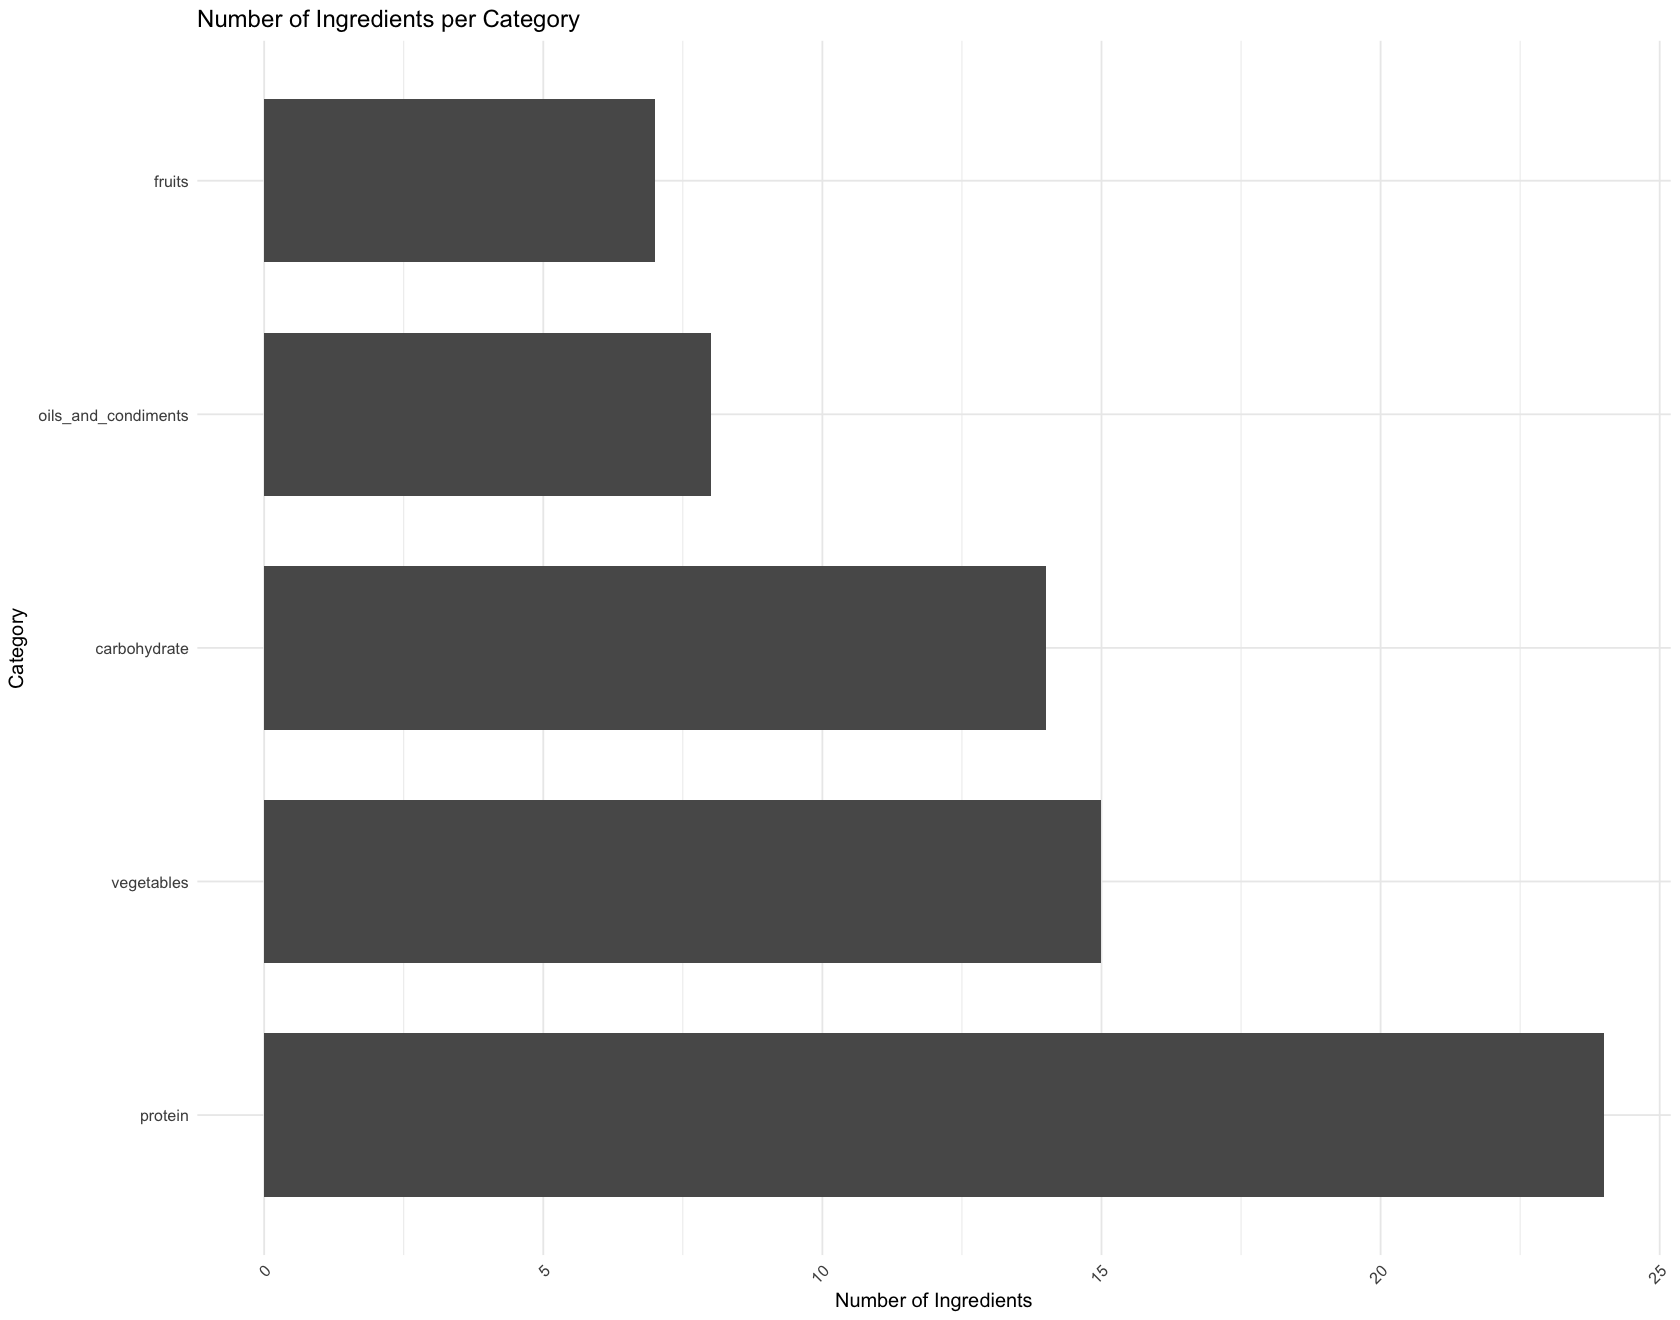

In [63]:
# Create a bar plot showing number of items per category
library(ggplot2)
library(dplyr)

category_counts <- data.frame(
  Category = names(ingredient_categories),
  Count = sapply(ingredient_categories, length)
)

ggplot(category_counts, aes(x = reorder(Category, -Count), y = Count)) +
  geom_col(width = 0.7) +
  coord_flip() +
  theme_minimal() +
  labs(
    title = "Number of Ingredients per Category",
    x = "Category",
    y = "Number of Ingredients"
  ) +
  theme(
    text = element_text(size = 12),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

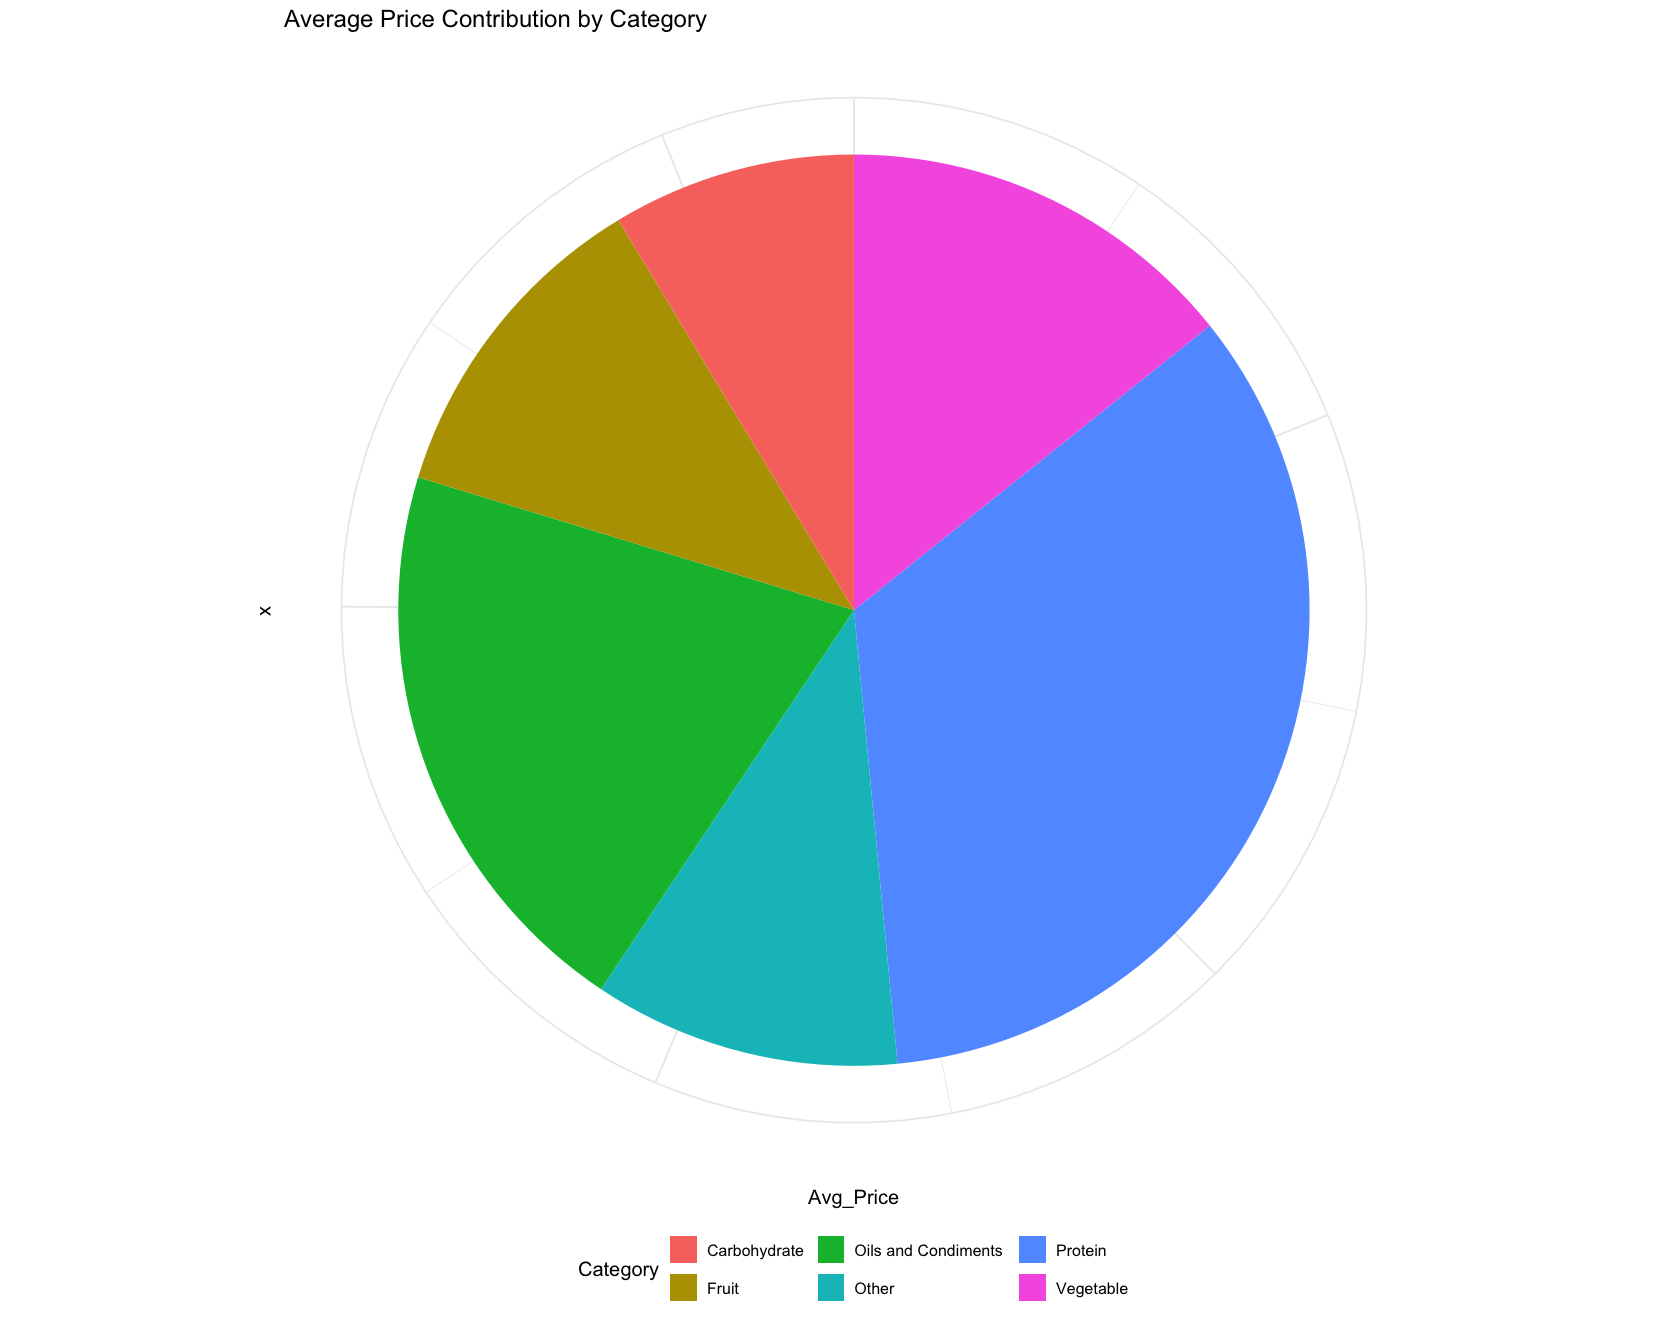

In [65]:
# Calculate average prices by category
category_prices <- food_prices %>%
  group_by(Category) %>%
  summarise(Avg_Price = mean(UnitPrice_kg)) %>%
  arrange(desc(Avg_Price))

# Create a pie chart
ggplot(category_prices, aes(x = "", y = Avg_Price, fill = Category)) +
  geom_col(width = 1) +
  coord_polar(theta = "y") +
  theme_minimal() +
  theme(
    text = element_text(size = 12),
    legend.position = "bottom",
    axis.text = element_blank()
  ) +
  labs(
    title = "Average Price Contribution by Category",
    fill = "Category"
  )

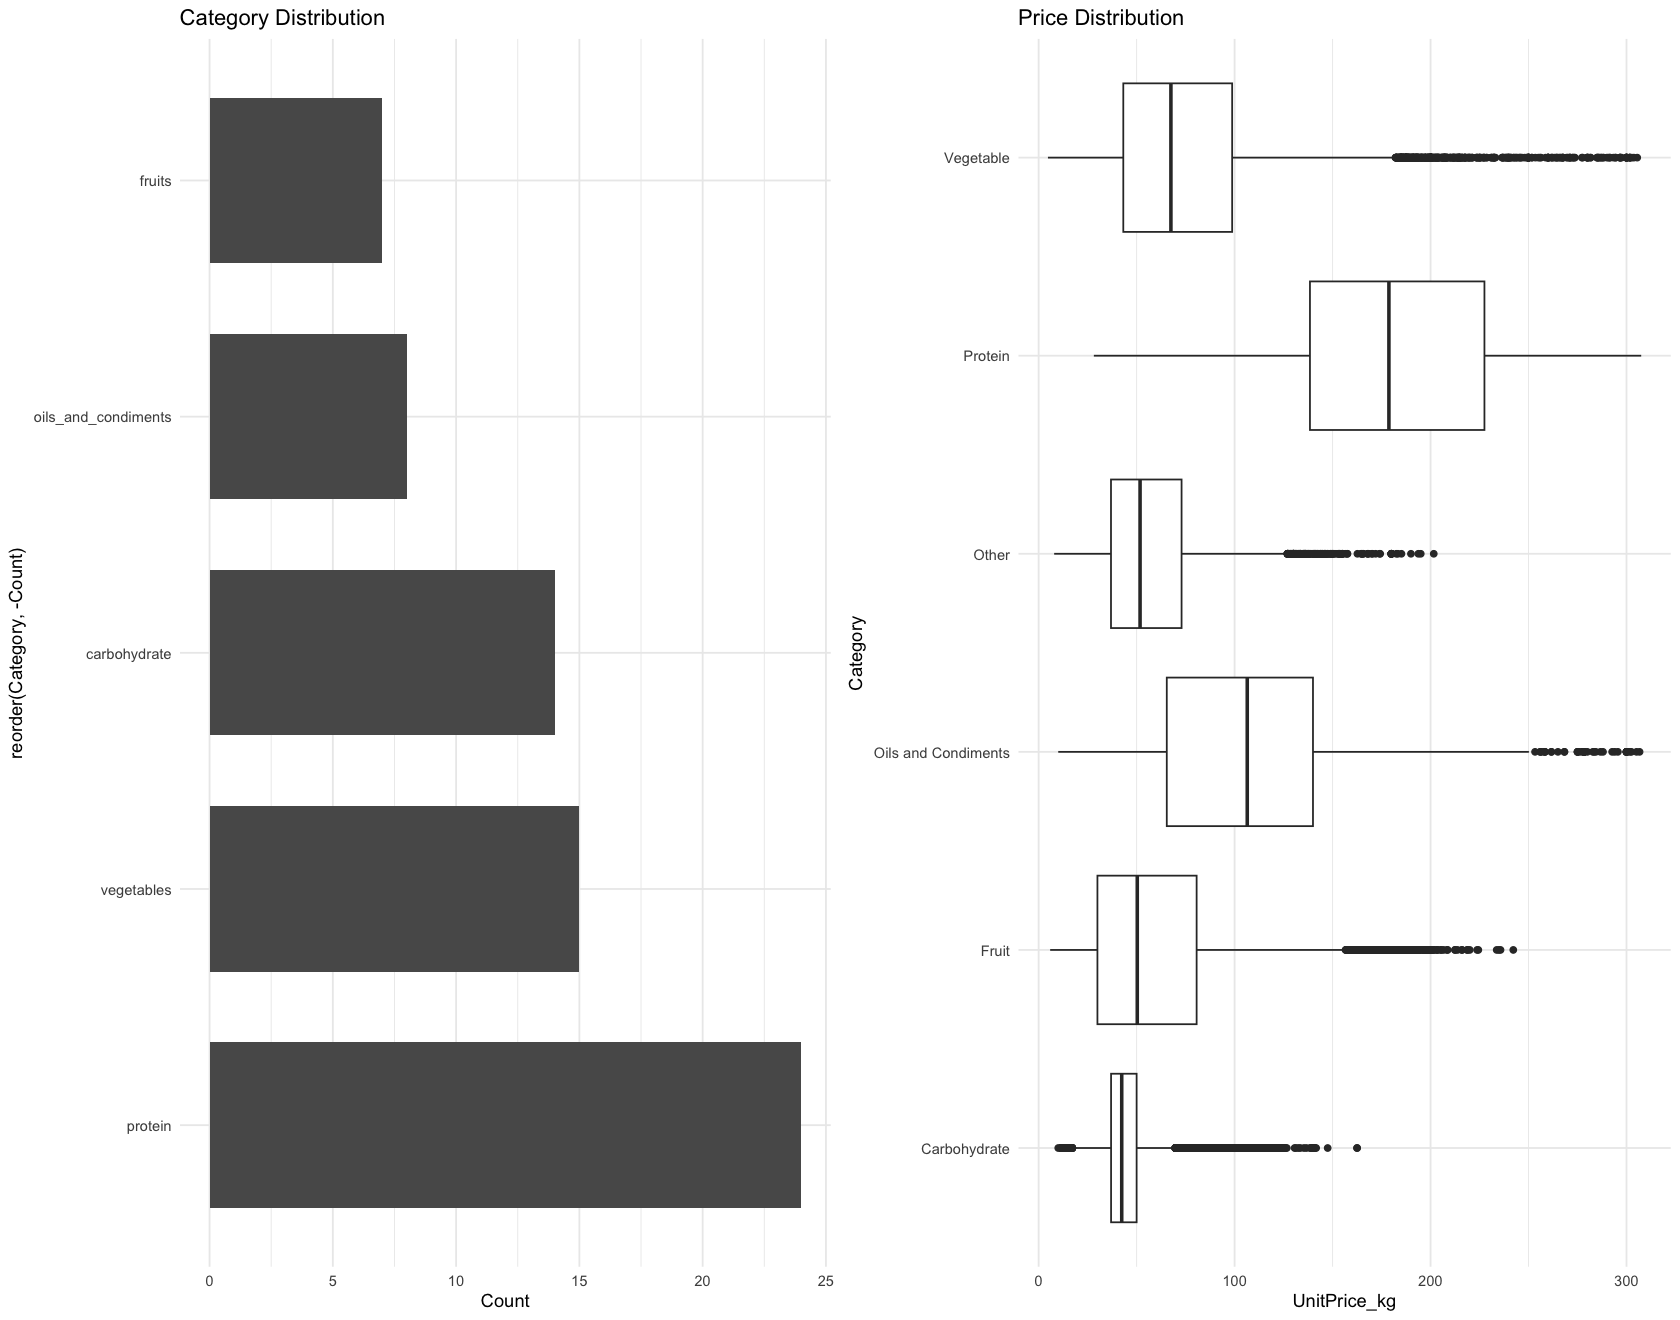

In [66]:
# Create a multi-panel visualization
library(gridExtra)

# Create individual plots
p1 <- ggplot(category_counts, aes(x = reorder(Category, -Count), y = Count)) +
  geom_col(width = 0.7) +
  coord_flip() +
  theme_minimal() +
  labs(title = "Category Distribution")

p2 <- ggplot(food_prices, aes(x = Category, y = UnitPrice_kg)) +
  geom_boxplot() +
  coord_flip() +
  theme_minimal() +
  labs(title = "Price Distribution")

# Combine plots
grid.arrange(p1, p2, ncol = 2)

Distribution of Food Prices by Category

Understanding the distribution of prices within each category can help in setting realistic meal allowances. A box plot can effectively visualize this distribution.

Explanation: This box plot illustrates the range and variability of prices within each food category. It's useful for identifying categories with high price variability, which might require more flexible meal allowances.

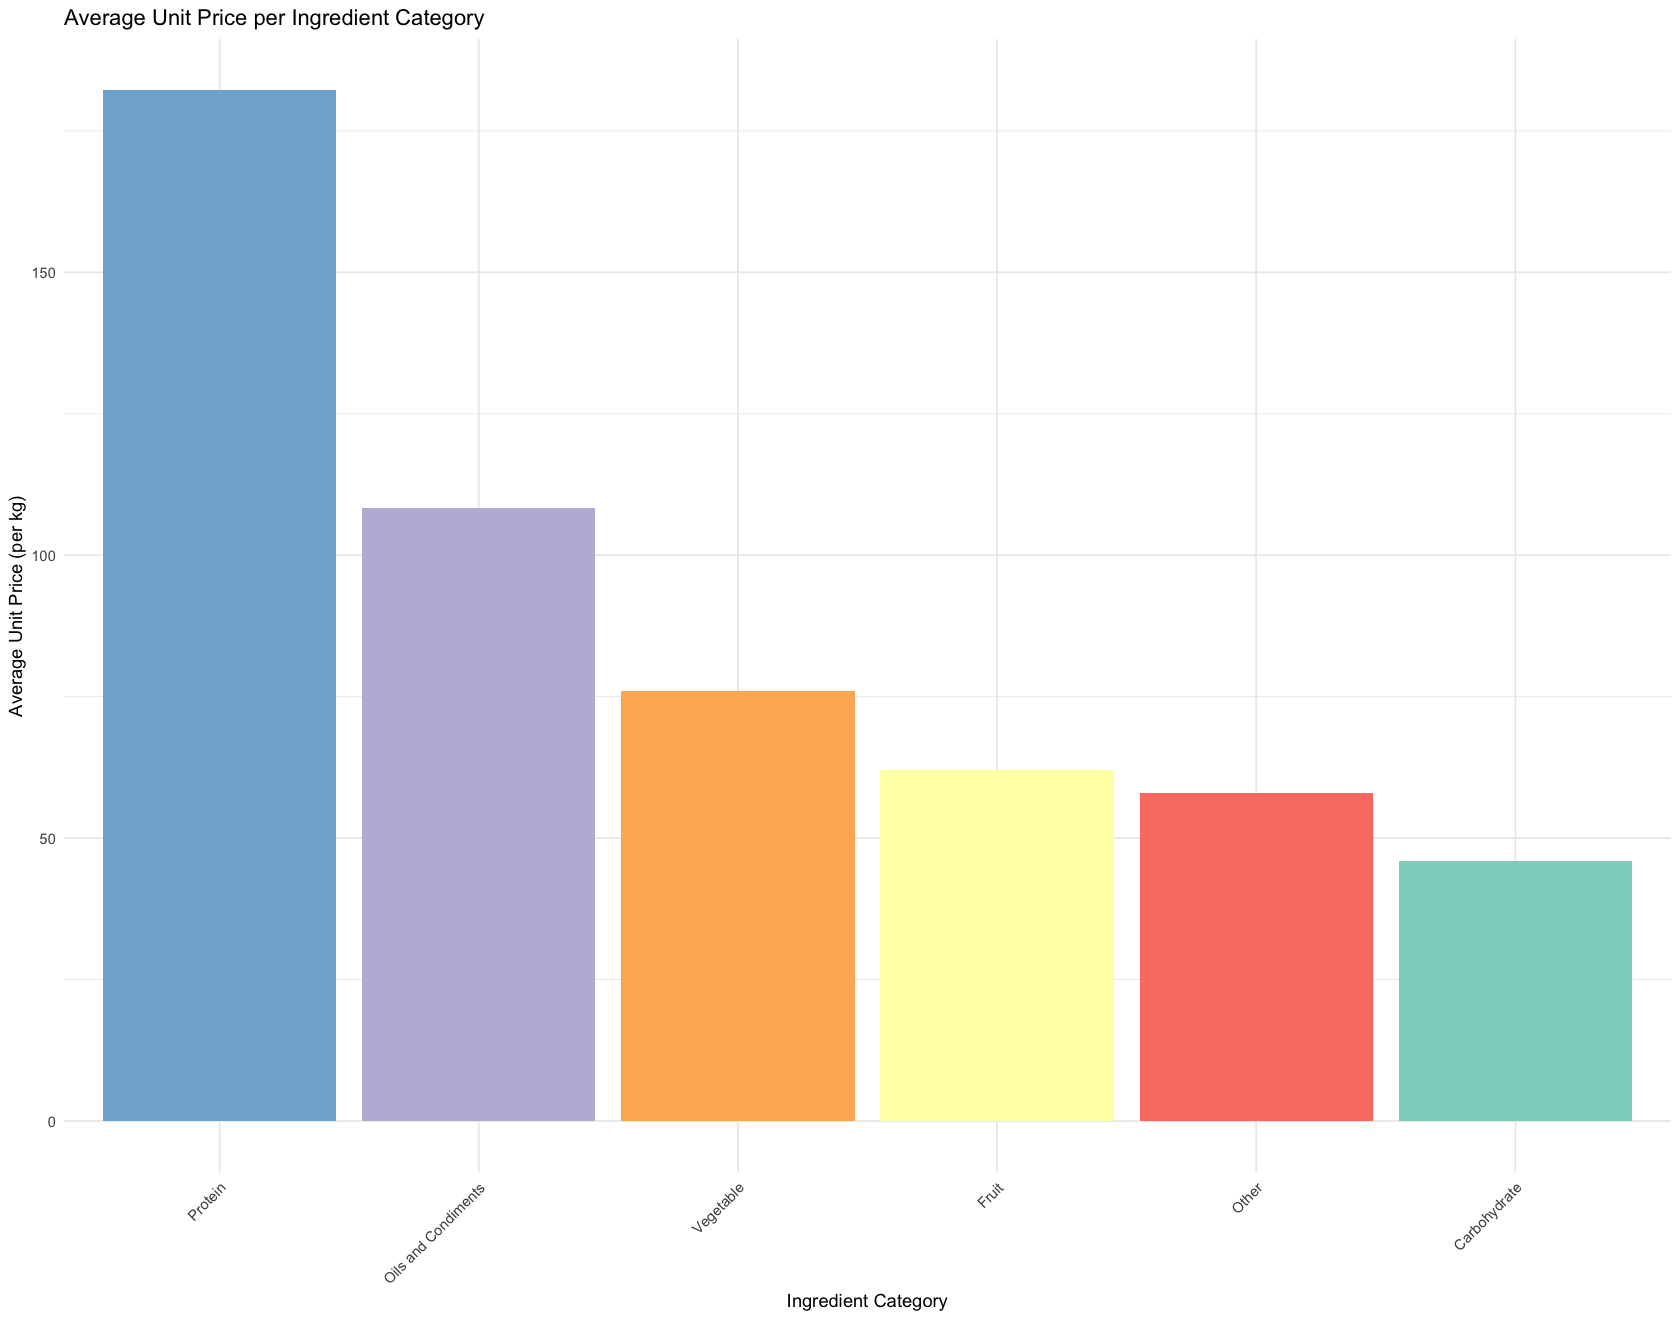

In [77]:
# Average unit price per category
#  Category Distribution Visualization
# This visualization helps understand the composition of your ingredient categories. 
# The horizontal bar chart makes it easy to compare category sizes, and the reorder() function ensures categories are arranged by size for better visualization.
avg_price <- food_prices %>%
  group_by(Category) %>%
  summarise(Avg_UnitPrice = mean(UnitPrice_kg, na.rm = TRUE)) %>%
  arrange(desc(Avg_UnitPrice))

# Bar plot
ggplot(avg_price, aes(x = reorder(Category, -Avg_UnitPrice), y = Avg_UnitPrice, fill = Category)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set3") +
  labs(title = "Average Unit Price per Ingredient Category",
       x = "Ingredient Category",
       y = "Average Unit Price (per kg)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [86]:
# Actual CPI data from PSA (2018=100)
cpi_data <- data.frame(
  Year = 2018:2022, # Include 2018
  CPI = c(97.2, 101.5, 104.5, 108.4, 113.8) # Include 2018 CPI
)

# Calculate inflation rates
cpi_data <- cpi_data %>%
  mutate(
    Previous_CPI = lag(CPI),
    Inflation_Rate = ifelse(is.na(Previous_CPI), 0, (CPI - Previous_CPI) / Previous_CPI)
  )

# Base meal allowance (from Option 1)
base_allowance <- 300 # PHP

# Calculate adjusted allowance for each year
allowance_data <- cpi_data %>%
  mutate(
    Adjusted_Allowance = base_allowance * (1 + Inflation_Rate)
  )

print(allowance_data)

  Year   CPI Previous_CPI Inflation_Rate Adjusted_Allowance
1 2018  97.2           NA     0.00000000           300.0000
2 2019 101.5         97.2     0.04423868           313.2716
3 2020 104.5        101.5     0.02955665           308.8670
4 2021 108.4        104.5     0.03732057           311.1962
5 2022 113.8        108.4     0.04981550           314.9446


In [88]:
# Actual CPI data from PSA (2018=100)
cpi_data <- data.frame(
  Year = 2018:2022,
  CPI = c(97.2, 101.5, 104.5, 108.4, 113.8)
)

# Calculate inflation rates
cpi_data <- cpi_data %>%
  mutate(
    Previous_CPI = lag(CPI),
    Inflation_Rate = ifelse(is.na(Previous_CPI), 0, (CPI - Previous_CPI) / Previous_CPI)
  )

# Base meal allowance (from Option 1)
base_allowance <- 300 # PHP

# Calculate adjusted allowances
allowance_data <- cpi_data %>%
  mutate(
    Adjusted_Allowance_CPI = base_allowance * (1 + Inflation_Rate),
    COLA_Rate = pmin(Inflation_Rate * 0.8, 0.05),
    Adjusted_Allowance_COLA = base_allowance * (1 + COLA_Rate)
  ) %>%
  select(Year, CPI, Inflation_Rate, COLA_Rate, Adjusted_Allowance_CPI, Adjusted_Allowance_COLA)

print(allowance_data)

  Year   CPI Inflation_Rate  COLA_Rate Adjusted_Allowance_CPI
1 2018  97.2     0.00000000 0.00000000               300.0000
2 2019 101.5     0.04423868 0.03539095               313.2716
3 2020 104.5     0.02955665 0.02364532               308.8670
4 2021 108.4     0.03732057 0.02985646               311.1962
5 2022 113.8     0.04981550 0.03985240               314.9446
  Adjusted_Allowance_COLA
1                300.0000
2                310.6173
3                307.0936
4                308.9569
5                311.9557


In [89]:
# Create the linear regression model
model <- lm(Base_Meal_Price ~ Year, data = yearly_avg_prices)

# Get the model summary (optional, for diagnostics)
summary(model)


Call:
lm(formula = Base_Meal_Price ~ Year, data = yearly_avg_prices)

Residuals:
      1       2       3       4 
-3.1552  4.5889  0.2879 -1.7215 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -13049.167   3728.902  -3.499   0.0728 .
Year             6.487      1.846   3.515   0.0723 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.127 on 2 degrees of freedom
Multiple R-squared:  0.8607,	Adjusted R-squared:  0.791 
F-statistic: 12.36 on 1 and 2 DF,  p-value: 0.07227


In [90]:
# Create a data frame for future years (e.g., 2023 and 2024)
future_years <- data.frame(Year = (max(yearly_avg_prices$Year) + 1):(max(yearly_avg_prices$Year) + 2))

# Predict future meal prices
forecast <- predict(model, newdata = future_years)

# Combine future years and forecasted prices
forecast_data <- data.frame(Year = future_years$Year, Forecasted_Price = forecast)

# Print the forecast
print(forecast_data)

  Year Forecasted_Price
1 2023         74.92093
2 2024         81.40837


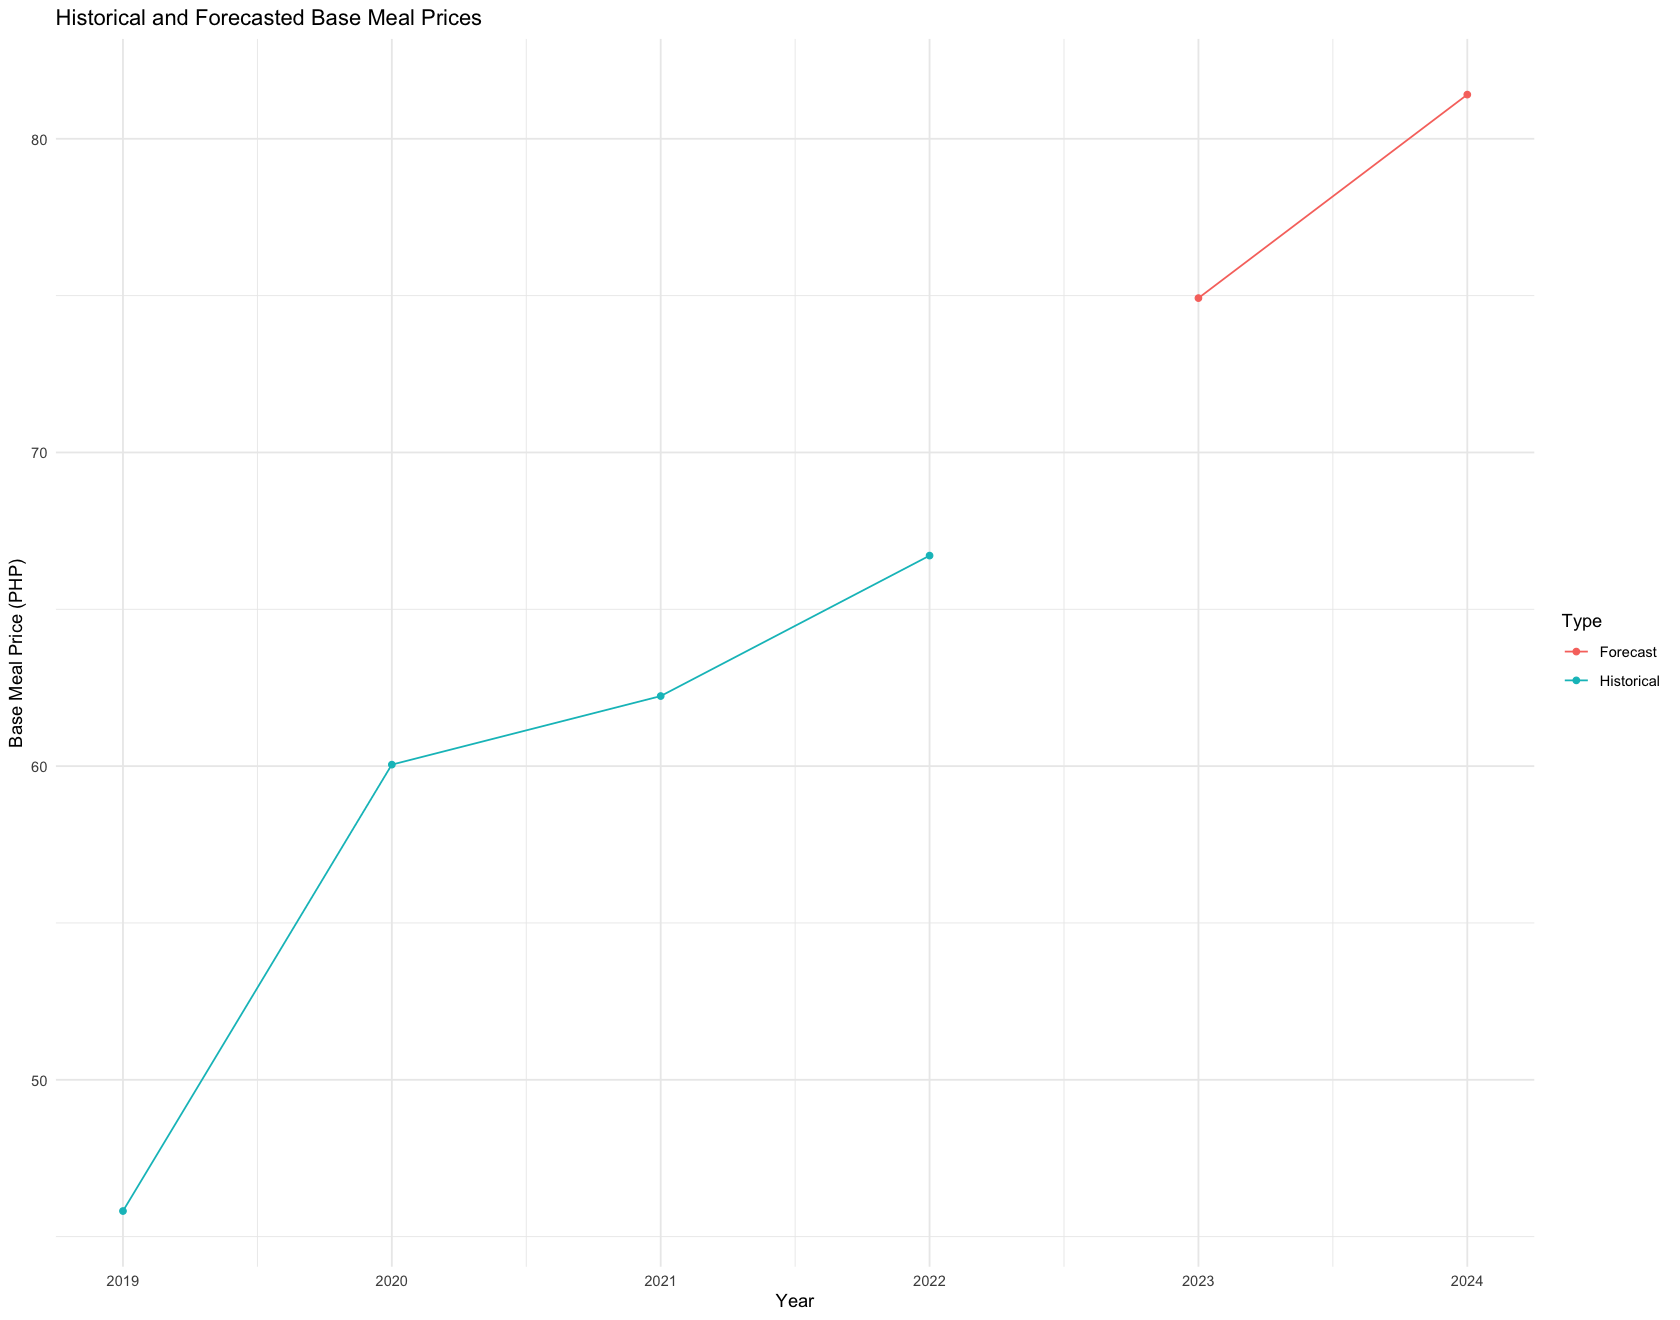

In [91]:
# Combine historical and forecasted data
all_data <- rbind(
  yearly_avg_prices %>% select(Year, Base_Meal_Price) %>% mutate(Type = "Historical"),
  forecast_data %>% rename(Base_Meal_Price = Forecasted_Price) %>% mutate(Type = "Forecast")
)

# Plot the historical and forecasted meal prices
ggplot(all_data, aes(x = Year, y = Base_Meal_Price, color = Type)) +
  geom_line() +
  geom_point() +
  labs(title = "Historical and Forecasted Base Meal Prices", x = "Year", y = "Base Meal Price (PHP)") +
  theme_minimal()